# HAN复现，使用tensorflow2

HAN全称：Heterogeneous Graph Attention Network[^1]。本notebook中**使用数据集ACM按照论证中相同的数据预处理，然后进行实验**。

[^1]: Wang X, Ji H, Shi C, et al. Heterogeneous graph attention network[C]//The World Wide Web Conference. 2019: 2022-2032.

# 基本思想

分层式注意力机制。

通过Meta-path，结合Random Walk进行边的采样，构建多组Meta-path，每组Meta-path中，对目标节点作为起始点采样邻接点(Random Walk下的邻接点)，通过注意力机制进行信息传递，这一层注意力机制称之为：**Node-level Attention**。

对于多组Meta-path，也通过一层注意力机制进行消息传递，这一层注意力机制称之为：**Semantic-level Attention**。

# 工作流

1. 对于所有输入节点，先通过转移矩阵变换到同一空间（相同类型节点使用一个转移矩阵，不同类型节点使用不同转移矩阵）。
2. 对于一条Meta-path上的一个节点，计算与Meta-path上邻接点的注意力系数。
3. 分别按照每条Meta-path进行节点表示更新
4. 聚合多条Meta-path上的节点表示。注：虽然这层引入了转移矩阵，只用于计算注意力系数，但是并不影响输出的维度。

# 创新

- 第一次尝试通过基于注意力机制的异质图神经网络研究。
- 提出了一个新颖的双层注意力框架，同时考虑节点和Meta-path的重要性。
- 复杂度是基于元路径节点对的线性。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import tensorflow as tf
import scipy.io as sio
import scipy.sparse as sp
from tensorflow import keras
import warnings
from pathlib import Path
import pickle

# 1. 导入数据

In [2]:
data_path = Path('../datasets/ACM/ACM3025.mat')
data_path.exists()

True

In [3]:
data_path

PosixPath('../datasets/ACM/ACM3025.mat')

In [4]:
data = sio.loadmat(data_path)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'PTP', 'PLP', 'PAP', 'feature', 'label', 'train_idx', 'val_idx', 'test_idx'])

In [5]:
features = data['feature'].astype(np.float32)
# papers-subjects-papers
PSP = data['PLP'].astype(np.float32)
# papers-authors-papers
PAP = data['PAP'].astype(np.float32)
labels = data['label'].astype(np.float32)
train_idx, val_idx, test_idx = data['train_idx'], data['val_idx'], data['test_idx']

In [6]:
labels = np.argmax(labels, axis=1)

In [9]:
node_num = features.shape[0]
feature_dim = features.shape[1]
num_classes = 3

In [10]:
base = np.zeros(shape=(node_num, ), dtype=np.bool)
train_mask = np.copy(base)
val_mask = np.copy(base)
test_mask = np.copy(base)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

In [11]:
data_path_ = data_path.parent / 'acm_data.pkl'

In [12]:
data_ = {'features': features, 'labels':labels, 'PSP':PSP, 
         'PAP':PAP, 'train_mask':train_mask, 'val_mask':val_mask,
        'test_mask': test_mask}
pickle.dump(data_, data_path_.open('wb'))

# 2. NodeAttention

In [13]:
class NodeAttention(keras.layers.Layer):
    '''
    virtually a GAT layer
    '''
    def __init__(self, 
                 units, 
                 initializer='glorot_normal', 
                 regularizer='l2', 
                 heads=1, 
                 activation='elu', 
                 dropout_rate=0.6, 
                 use_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.heads = heads
        self.dropout_rate = dropout_rate
        self.use_bias = use_bias
        
        self.kernel_initializer = keras.initializers.get(initializer)
        self.regularizer = keras.regularizers.get(regularizer)
        self.activation = keras.activations.get(activation)
        
        self.output_dim = self.units * self.heads
        self.kernels = []
        if use_bias:
            self.bias = []
        self.att_kernels = []
    
    
    def build(self, input_shape):
        for head in range(self.heads):
            kernel = self.add_weight(shape=(input_shape[0][-1], self.units), 
                                     initializer=self.kernel_initializer,
                                     regularizer=self.regularizer,)
            self.kernels.append(kernel)
            if self.use_bias:
                bias = self.add_weight(shape=(self.units, ), 
                                       regularizer=self.regularizer,
                                      initializer='zeros')
                self.bias.append(bias)
            att_kernel_self = self.add_weight(shape=(self.units, 1), 
                                         initializer=self.kernel_initializer,
                                         regularizer=self.regularizer)
            att_kernel_neighbors = self.add_weight(shape=(self.units, 1), 
                                         initializer=self.kernel_initializer,
                                         regularizer=self.regularizer)
            self.att_kernels.append([att_kernel_self, att_kernel_neighbors])
        super().__init__()
    
    
    def call(self, inputs, training=False):
        X, A = inputs
        outputs = []
        for head in range(self.heads):
            kernel = self.kernels[head]
            att_kernel = self.att_kernels[head]
            
            X_ = X @ kernel
            att_self = X_ @ att_kernel[0]
            att_neighbors = X_ @ att_kernel[1]
            
            a_weight = att_self + tf.transpose(att_neighbors)
            a_weight = tf.nn.leaky_relu(a_weight, alpha=0.2)
            a_weight += -10e9 * (1-A)
            a_weight = tf.nn.softmax(a_weight)
            
            if training:
                dropout_att = tf.nn.dropout(a_weight, 
                                            rate=self.dropout_rate)
#                 dropout_X_ = tf.nn.dropout(X_, 
#                                            rate=self.dropout_rate)
                dropout_X_ = tf.nn.dropout(X_, 
                                           rate=0.0)
                node_features = dropout_att @ dropout_X_
            else:
                node_features = a_weight @ X_
            
            if self.use_bias:
                node_features += self.bias[head]
            outputs.append(node_features)
        
        output = tf.concat(outputs, axis=1)
        return self.activation(output)
    
    def compute_output_shape(self, input_shape):
        output_shape = input_shape[0][0], self.output_dim
        return tf.TensorShape(output_shape)

# 3. SemanticAttention

In [14]:
class SemanticAttention(keras.layers.Layer):
    def __init__(self, 
                 units,
                 meta_paths_num,
                 activation='linear',
                 regularizer='l2',
                 initializer='glorot_normal',
                 use_bias=True):
        super().__init__()
        self.units = units
        self.use_bias = use_bias
        self.meta_paths_num = meta_paths_num
        self.activation = keras.activations.get(activation)
        self.regularizer = keras.regularizers.get(regularizer)
        self.initializer = keras.initializers.get(initializer)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[0][-1], self.units),
                                 initializer=self.initializer,
                                 regularizer=self.regularizer,)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units, ),
                                  initializer='zeros',
                                  regularizer=self.regularizer)
        self.att_kernel = self.add_weight(shape=(self.units, 1),
                                    initializer=self.initializer,
                                    regularizer=self.regularizer)
        super().__init__()
        
    def call(self, inputs, training=False):
        assert len(inputs) == self.meta_paths_num
        
        att_weights = [None for i in range(self.meta_paths_num)]
        for idx in range(self.meta_paths_num):            
            tmp = inputs[idx] @ self.kernel
            if self.use_bias:
                tmp += self.bias
            tmp = tf.nn.tanh(tmp)
            tmp = tmp @ self.att_kernel
            tmp = tf.reduce_mean(tmp)
            
            att_weights[idx] = tmp
        
        att_weights = tf.nn.softmax(att_weights)
        output = 0
        for i in range(self.meta_paths_num):
            output += att_weights[i] * inputs[i]
        return self.activation(output)

# 4. 参数设置

- 优化器：Adam，学习率0.005
- 参数正则化：0.001
- semantic层注意力向量维数：128
- 多头注意力个数：8
- dropout rate：0.6
- early-stopping：patience(valid loss) 100
- loss：category crossentropy
- metrics：Macro-F1，Micro-F1
- activation：elu

In [26]:
# model parameters
batch_size  = 1
semantic_hidden_size = 128
att_heads   = 8
hidden_size = 64 # hidden_size * att_heads = 64
lr          = 0.005
patience    = 100
l2_coef     = 0.001
dropout_rate= 0.6
activation  = 'elu'
optimizer   = keras.optimizers.Adam(learning_rate=lr)
regularizer = keras.regularizers.L2(l2=l2_coef)
loss        = keras.losses.SparseCategoricalCrossentropy()

In [16]:
node_num, feature_dim, num_classes

(3025, 1870, 3)

# 5. 构建模型

In [86]:
def HAN(node_num=node_num, 
        feature_dim=feature_dim, 
        dropout_rate=dropout_rate, 
        hidden_size=hidden_size,
        regularizer=regularizer,
        att_heads=att_heads,
        semantic_hidden_size=semantic_hidden_size,
        num_classes=num_classes
       ):
    X = keras.Input(shape=(feature_dim, ))
    dropout1 = keras.layers.Dropout(dropout_rate)(X)
    dropout2 = keras.layers.Dropout(dropout_rate)(X)
    PSP = keras.Input(shape=(node_num, ))
    PAP = keras.Input(shape=(node_num, ))
    node_layer1 = NodeAttention(units=hidden_size, 
                                regularizer=regularizer, 
                                heads=att_heads, dropout_rate=dropout_rate)([dropout1, PSP])
    node_layer2 = NodeAttention(units=hidden_size,
                                regularizer=regularizer,
                                heads=att_heads, dropout_rate=dropout_rate)([dropout2, PAP])
    semantic_layer1 = SemanticAttention(units=semantic_hidden_size, 
                                       meta_paths_num=2)([node_layer1, 
                                                          node_layer2])
    dropout3 = keras.layers.Dropout(dropout_rate)(semantic_layer1)
    dropout4 = keras.layers.Dropout(dropout_rate)(semantic_layer1)
    node_layer3 = NodeAttention(units=num_classes, heads=1, dropout_rate=dropout_rate, 
                                regularizer=regularizer)([dropout3, PSP])
    node_layer4 = NodeAttention(units=num_classes, heads=1, dropout_rate=dropout_rate,
                                regularizer=regularizer)([dropout4, PAP])
    semantic_layer2 = SemanticAttention(units=num_classes,
                                        meta_paths_num=2,
                                        regularizer=regularizer,
                                        activation='softmax' )([node_layer3, 
                                                               node_layer4])
    model = keras.Model(inputs=[X, PSP, PAP], outputs=semantic_layer2)
    return model

# 6. 训练与评估

## 6.1 采用Accuracy作为指标训练

输入数据tf化，此处**仅使用Accuracy**作为评估指标

In [18]:
labels = tf.convert_to_tensor(labels, dtype=tf.int32)
features = tf.convert_to_tensor(features, dtype=tf.float32)
PSP = tf.convert_to_tensor(PSP, dtype=tf.float32)
PAP = tf.convert_to_tensor(PAP, dtype=tf.float32)

train_mask = tf.convert_to_tensor(train_mask, dtype=tf.float32)
val_mask = tf.convert_to_tensor(val_mask, dtype=tf.float32)
test_mask = tf.convert_to_tensor(test_mask, dtype=tf.float32)

Epoch 1/1000
1/1 - 1s - loss: 0.2211 - acc: 0.3500 - val_loss: 0.1023 - val_acc: 0.6567
Epoch 2/1000
1/1 - 0s - loss: 0.2058 - acc: 0.5750 - val_loss: 0.0851 - val_acc: 0.7933
Epoch 3/1000
1/1 - 0s - loss: 0.1737 - acc: 0.7150 - val_loss: 0.0788 - val_acc: 0.6467
Epoch 4/1000
1/1 - 0s - loss: 0.1588 - acc: 0.6850 - val_loss: 0.0642 - val_acc: 0.9500
Epoch 5/1000
1/1 - 0s - loss: 0.1307 - acc: 0.8533 - val_loss: 0.0498 - val_acc: 0.9467
Epoch 6/1000
1/1 - 0s - loss: 0.1124 - acc: 0.8833 - val_loss: 0.0365 - val_acc: 0.9533
Epoch 7/1000
1/1 - 0s - loss: 0.0932 - acc: 0.9017 - val_loss: 0.0319 - val_acc: 0.9400
Epoch 8/1000
1/1 - 0s - loss: 0.0820 - acc: 0.8933 - val_loss: 0.0330 - val_acc: 0.8200
Epoch 9/1000
1/1 - 0s - loss: 0.1270 - acc: 0.7667 - val_loss: 0.0305 - val_acc: 0.9200
Epoch 10/1000
1/1 - 0s - loss: 0.0798 - acc: 0.8617 - val_loss: 0.0294 - val_acc: 0.9133
Epoch 11/1000
1/1 - 0s - loss: 0.0893 - acc: 0.8383 - val_loss: 0.0203 - val_acc: 0.9467
Epoch 12/1000
1/1 - 0s - loss:

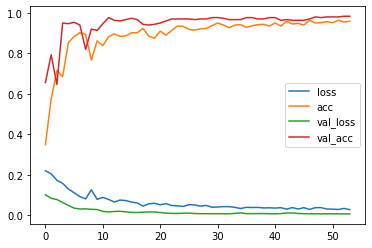

In [94]:
optimizer   = keras.optimizers.Adam(learning_rate=0.005)
regularizer = keras.regularizers.L2(l2=0.005)
es_min_delta = 0.01
es_patience = 30
epochs = 1000
dropout_rate = 0.55
hidden_size = 8

model = HAN(dropout_rate=dropout_rate, hidden_size=hidden_size)
model.compile(optimizer=optimizer, 
              weighted_metrics=['acc'],
              loss='sparse_categorical_crossentropy')

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=es_patience, 
                                            min_delta=es_min_delta)

val_data = ([features, PSP, PAP], labels, val_mask)
history = model.fit([features, PSP, PAP], labels,
          sample_weight=train_mask,
          batch_size=node_num,
          epochs=epochs,
          validation_data=val_data,
          shuffle=False, verbose=2, callbacks=es_callback)
for i, item in history.history.items():
    plt.plot(item, label=i)
plt.legend()

print()
for i in [train_mask, val_mask, test_mask]:
    print(model.evaluate([features, PSP, PAP], labels, sample_weight=i, batch_size=node_num, verbose=2))

## 6.2 使用Macro F1和Micro F1作为指标进行训练

自定义训练循环，并**使用Micro F1和Macro F1**作为评估指标。

In [24]:
import tensorflow_addons as tfa

In [27]:
# @tf.function
def train_model(model, inputs, labels, 
                mask, f1_macro, f1_micro,
                num_classes=num_classes,
                optimizer=optimizer, loss=loss):
    with tf.GradientTape() as tape:
        y_preds = model(inputs, training=True)
        cur_loss = loss(labels, y_preds, sample_weight=mask)

    gradients = tape.gradient(cur_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    f1_macro.update_state(tf.one_hot(labels, 
                                            depth=num_classes), 
                                 y_preds, sample_weight=mask)
    f1_micro.update_state(tf.one_hot(labels, 
                                            depth=num_classes), 
                                 y_preds, sample_weight=mask)
    
    f1_macro_result = f1_macro.result()
    f1_micro_result = f1_micro.result()
    print(f'loss: {cur_loss.numpy()} - '
          f'macro_f1: {f1_macro_result.numpy()} - '
          f'micro_f1: {f1_micro_result.numpy()} - ', end='')
    f1_macro.reset_states()
    f1_micro.reset_states()
    
    # 用于Early Stopping
    return cur_loss, f1_macro_result, f1_micro_result

# @tf.function
def evaluate_model(model, inputs, labels, 
                   mask, f1_macro, f1_micro, 
                   loss=loss, type_='val'):
    y_preds = model(inputs, training=False)
    cur_loss = loss(labels, y_preds, sample_weight=mask)
    
    f1_macro.update_state(tf.one_hot(labels, 
                                            depth=num_classes), 
                                 y_preds, sample_weight=mask)
    f1_micro.update_state(tf.one_hot(labels, 
                                            depth=num_classes), 
                                 y_preds, sample_weight=mask)
    
    f1_macro_result = f1_macro.result()
    f1_micro_result = f1_micro.result()
    print(f'{type_}_loss: {cur_loss.numpy()} - '
          f'{type_}_macro_f1: {f1_macro_result.numpy()} - '
          f'{type_}_micro_f1: {f1_macro_result.numpy()}')
    f1_macro.reset_states()
    f1_micro.reset_states()
    
    # 用于Early Stopping
    return cur_loss, f1_macro_result, f1_micro_result

epoch: 1 - loss: 0.2196810096502304 - macro_f1: 0.3249158561229706 - micro_f1: 0.3449999988079071 - val_loss: 0.07828947901725769 - val_macro_f1: 0.5615355372428894 - val_micro_f1: 0.5615355372428894
epoch: 2 - loss: 0.16200777888298035 - macro_f1: 0.6232967972755432 - micro_f1: 0.653333306312561 - val_loss: 0.05558392405509949 - val_macro_f1: 0.5731135606765747 - val_micro_f1: 0.5731135606765747
epoch: 3 - loss: 0.16570624709129333 - macro_f1: 0.5888868570327759 - micro_f1: 0.6666666865348816 - val_loss: 0.14208956062793732 - val_macro_f1: 0.4886143207550049 - val_micro_f1: 0.4886143207550049
epoch: 4 - loss: 0.32567688822746277 - macro_f1: 0.49149179458618164 - micro_f1: 0.6029900908470154 - val_loss: 0.05089815333485603 - val_macro_f1: 0.7672169804573059 - val_micro_f1: 0.7672169804573059
epoch: 5 - loss: 0.15552569925785065 - macro_f1: 0.6100510358810425 - micro_f1: 0.6600000262260437 - val_loss: 0.20504051446914673 - val_macro_f1: 0.1666666716337204 - val_micro_f1: 0.1666666716337

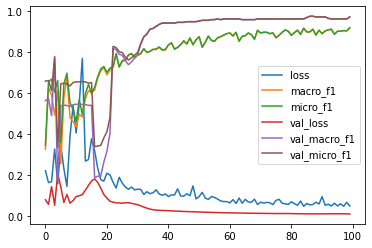

In [95]:
epoches = 50
dropout_rate = 0.55
hidden_size = 8
optimizer   = keras.optimizers.Adam(learning_rate=0.005)
regularizer = keras.regularizers.L2(l2=0.005)
es_min_delta = 0.01
es_patience = 30
epochs = 1000
dropout_rate = 0.55
hidden_size = 8

f1_macro = tfa.metrics.F1Score(num_classes, average='macro')
f1_micro = tfa.metrics.F1Score(num_classes, average='micro')
model = HAN(node_num=node_num, feature_dim=feature_dim, 
            dropout_rate=dropout_rate, 
            hidden_size=hidden_size,
           )
loss = keras.losses.SparseCategoricalCrossentropy()

history = {'loss': [], 
           'macro_f1': [], 
           'micro_f1': [], 
           'val_loss':[], 
           'val_macro_f1':[], 
           'val_micro_f1':[]}

for epoch in range(epoches):
    print(f'epoch: {epoch+1} - ', end='')
    loss_, f1_macro_, f1_micro_ = train_model(model, [features, PSP, PAP], labels, train_mask,
               f1_macro, f1_micro)
    history['loss'].append(loss_)
    history['macro_f1'].append(f1_macro_)
    history['micro_f1'].append(f1_micro_)
    
    loss_, f1_macro_, f1_micro_ = evaluate_model(model, [features, PSP, PAP], labels, val_mask,
               f1_macro, f1_micro, type_='val')
    history['val_loss'].append(loss_)
    history['val_macro_f1'].append(f1_macro_)
    history['val_micro_f1'].append(f1_micro_)

print('\nEvaluating on test data:')
evaluate_model(model, [features, PSP, PAP], labels, test_mask,
           f1_macro, f1_micro, type_='test')

for i, item in history.items():
    plt.plot(item, label=i)
plt.legend()

In [96]:
model.summary()

Model: "functional_107"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_166 (InputLayer)          [(None, 1870)]       0                                            
__________________________________________________________________________________________________
dropout_184 (Dropout)           (None, 1870)         0           input_166[0][0]                  
__________________________________________________________________________________________________
input_167 (InputLayer)          [(None, 3025)]       0                                            
__________________________________________________________________________________________________
dropout_185 (Dropout)           (None, 1870)         0           input_166[0][0]                  
_____________________________________________________________________________________